Training SARIMAX model...

SARIMAX Model Evaluation:
Mean Squared Error: 646.1172906571285
R-squared: 0.4678637417483531


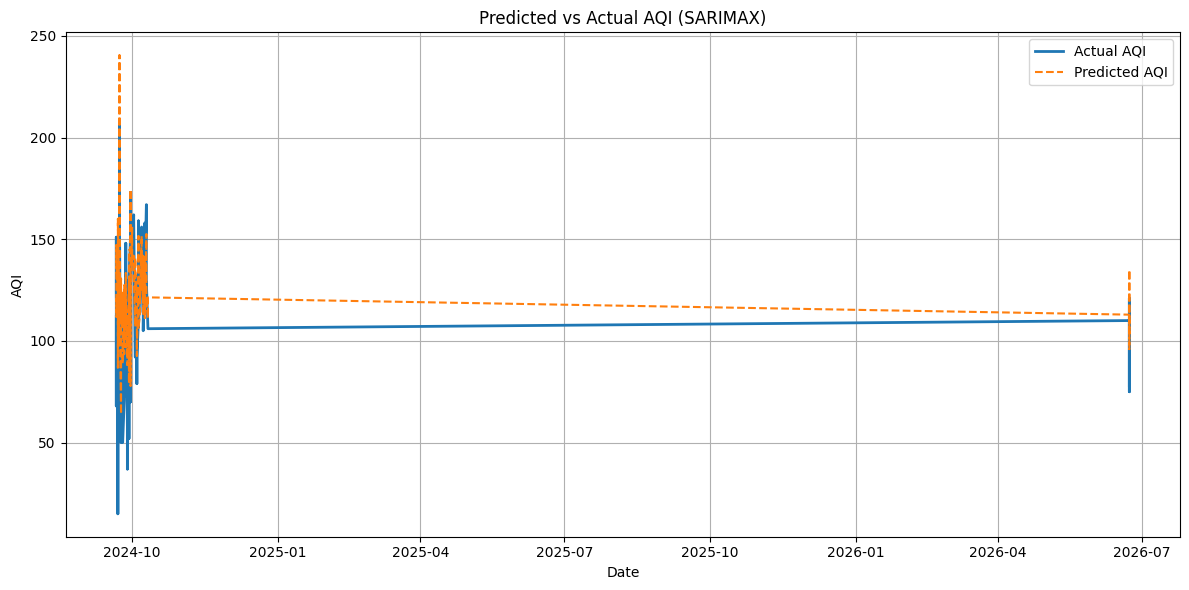

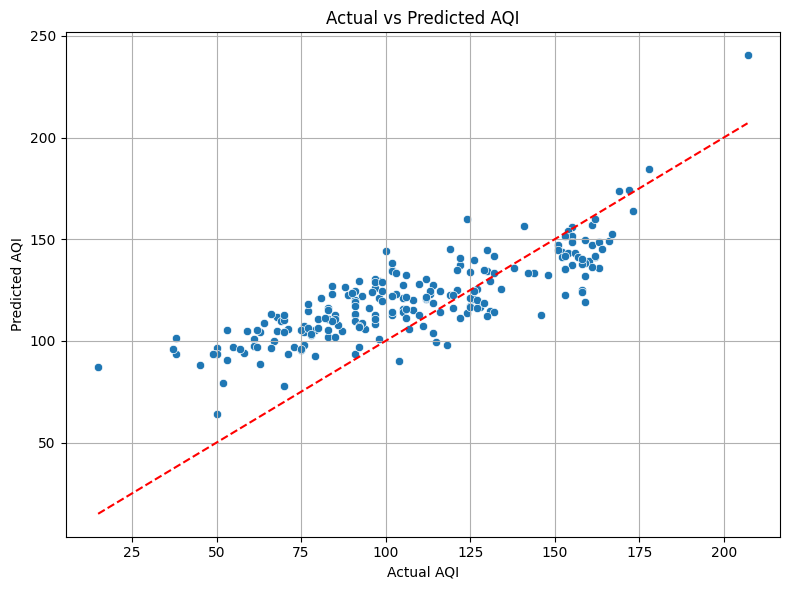

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load AQI and color data
color_data = pd.read_csv("/Users/samikazi/Desktop/Capstone Showcase/color_percentages.csv")
aqi_data_files = [
    "/Users/samikazi/Desktop/Capstone Showcase/CSE499A - Dhaka1.csv",
    "/Users/samikazi/Desktop/Capstone Showcase/CSE499A - Chittagong1.csv",
    "/Users/samikazi/Desktop/Capstone Showcase/CSE499A - Sylhet1.csv"
]

# Combine AQI + image color data
combined_data = []
for i in range(3):
    aqi_data = pd.read_csv(aqi_data_files[i])
    aqi_data['Date'] = pd.to_datetime(aqi_data['Date'], errors='coerce', dayfirst=True)
    
    for col in ['PM2.5', 'CO', 'NO2', 'Ozone(O3)', 'PM10', 'SO2']:
        aqi_data[col] = aqi_data[col].astype(str).str.replace(',', '.')
        aqi_data[col] = pd.to_numeric(aqi_data[col], errors='coerce')

    aqi_data.dropna(inplace=True)
    merged = pd.concat([
        aqi_data.reset_index(drop=True),
        color_data[['Red Percentage', 'Yellow Percentage', 'Green Percentage']].reset_index(drop=True)
    ], axis=1)
    merged.dropna(inplace=True)
    combined_data.append(merged)

# Combine all cities' data
final_data = pd.concat(combined_data).reset_index(drop=True)
final_data['Date'] = pd.to_datetime(final_data['Date'], errors='coerce', dayfirst=True)
final_data.dropna(subset=['Date'], inplace=True)
final_data.sort_values('Date', inplace=True)
final_data.set_index('Date', inplace=True)

# Add lag features to capture the temporal dependencies
lags = [1, 2, 3]
for lag in lags:
    final_data[f'Lag_{lag}'] = final_data['AQI'].shift(lag)

# Drop rows with NaN (from lag creation)
final_data.dropna(inplace=True)

# Define features and target
exog_vars = ['PM2.5', 'CO', 'NO2', 'Ozone(O3)', 'PM10', 'SO2', 'Red Percentage', 'Yellow Percentage', 'Green Percentage']
lag_features = [f'Lag_{lag}' for lag in lags]
X = final_data[exog_vars + lag_features]
y = final_data['AQI']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
train_size = int(0.8 * len(final_data))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Fit SARIMAX model
print("Training SARIMAX model...")
sarimax_model = SARIMAX(y_train,
                        exog=X_train,
                        order=(2, 1, 2),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_result = sarimax_model.fit(disp=False)

# Make predictions
y_pred = sarimax_result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nSARIMAX Model Evaluation:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot - Time Series
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual AQI', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted AQI', linestyle='--')
plt.title('Predicted vs Actual AQI (SARIMAX)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot - Actual vs Predicted (scatter with reset index to avoid seaborn error)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test.reset_index(drop=True), y=pd.Series(y_pred).reset_index(drop=True))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted AQI')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.grid(True)
plt.tight_layout()
plt.show()
